# Predict tags on StackOverflow with linear models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data

The following cell will download all data required for this assignment into the folder `week1/data`.

In [1]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submitting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [2]:
from grader import Grader

In [3]:
grader = Grader()

### Text preprocessing

For this and most of the following assignments you will need to use a list of stop words. It can be downloaded from *nltk*:

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bhargav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set is provided for Coursera's grading and doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [5]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [6]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [7]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [8]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [10]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. In this task you'll write a function, which will be also used in the other assignments. 

**Task 1 (TextPrepare).** Implement the function *text_prepare* following the instructions. After that, run the function *test_test_prepare* to test it on tiny cases and submit it to Coursera.

In [11]:
import re

In [12]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE,r" ", text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE,r"", text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    return text

In [13]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [14]:
print(test_text_prepare())

Basic tests are passed.


Run your implementation for questions from file *text_prepare_tests.tsv* to earn the points.

In [15]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [16]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [17]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

# Temp

In [ ]:
[0 for i in range(len(set(['r','a','a','b'])))]

In [ ]:
dict1 = {k:0 for k in set(['r','a','a','b']) }
dict1

In [ ]:
lt = y_train.tolist()
lt1=[]

for i in range(0,len(lt)):
    for j in range(len(lt[i])):
        lt1.append(lt[i][j])

In [ ]:
lt2=[]
for i in range(0,len(X_train)):
    for x in X_train[i].split():
        lt2.append(x)

In [ ]:
lt2

# Temp done

For each tag and for each word calculate how many times they occur in the train corpus. 

**Task 2 (WordsTagsCount).** Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [18]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

######################################
lt = y_train.tolist()
lt1=[]

for i in range(0,len(lt)):
    for j in range(len(lt[i])):
        lt1.append(lt[i][j])
        
tags_counts = {k:0 for k in set(lt1)}
for x in lt1:
    tags_counts[x] += 1

lt2=[]
for i in range(0,len(X_train)):
    for x in X_train[i].split():
        lt2.append(x)
words_counts = {k:0 for k in set(lt2)}
for x in lt2:
    words_counts[x] += 1
######################################

We are assuming that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`. The grader gets the results in the following format (two comma-separated strings with line break):

    tag1,tag2,tag3
    word1,word2,word3

Pay attention that in this assignment you should not submit frequencies or some additional information.

In [19]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


In [77]:
DICT_SIZE = 10000
WORDS_TO_INDEX = {x:i for i,x in enumerate([x for x,y in sorted(words_counts.items(), key=lambda x: x[1], reverse=True)])}
INDEX_TO_WORDS = {i:x for i,x in enumerate([x for x,y in sorted(words_counts.items(), key=lambda x: x[1], reverse=True)])}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for x in text.split():
        try:
            if(words_to_index[x] <= dict_size):
                result_vector[words_to_index[x]] += 1
                
        except:
            next
    
    return result_vector

In [78]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [79]:
print(test_my_bag_of_words())

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [23]:
from scipy import sparse as sp_sparse

In [80]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 10000)
X_val shape  (30000, 10000)
X_test shape  (20000, 10000)


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

**Task 3 (BagOfWords).** For the 11th row in *X_train_mybag* find how many non-zero elements it has. In this task the answer (variable *non_zero_elements_count*) should be a number, e.g. 20.

In [81]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row)

grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 7...


#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9,token_pattern=r"(\S+)")
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [29]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [30]:
######### YOUR CODE HERE #############
tfidf_vocab['c++']

1976

If you can't find it, we need to understand how did it happen that we lost them? It happened during the built-in tokenization of TfidfVectorizer. Luckily, we can influence on this process. Get back to the function above and use '(\S+)' regexp as a *token_pattern* in the constructor of the vectorizer.  

Now, use this transormation for the data and check again.

In [31]:
######### YOUR CODE HERE #############
tfidf_vocab['c#']

1879

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [32]:
from sklearn.preprocessing import MultiLabelBinarizer

In [33]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [34]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [66]:
def train_classifier(X_train, y_train, penalty='l2', c=0.1, classifier='logisticreg'):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    
    
    
    if (classifier == 'logisticreg'):
        lreg = LogisticRegression(penalty=penalty,verbose=0, C=c,max_iter=100)
        ovr = OneVsRestClassifier(estimator=lreg)
    else:
        ridge = RidgeClassifier(alpha=c)
        ovr = OneVsRestClassifier(estimator=ridge)
    model = ovr.fit(X_train,y_train)

    return model

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [67]:
classifier_mybag = train_classifier(X_train_mybag, y_train, penalty='l1',c=3.5)
classifier_tfidf = train_classifier(X_train_tfidf, y_train, penalty='l1',c=3.5)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [68]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [69]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(0,3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [56]:
def print_evaluation_scores(y_val, predicted):
    acc = accuracy_score(y_true=y_val,y_pred=predicted)
    f1 = f1_score(y_val,predicted,average='weighted')
    precision = average_precision_score(y_val,predicted)
    print("Accuracy = {}\nF1-Score = {}\nPrecision = {}".format(acc,f1,precision))

In [70]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy = 0.35386666666666666
F1-Score = 0.657396172194714
Precision = 0.34196449922420824
Tfidf
Accuracy = 0.36643333333333333
F1-Score = 0.6627457220694383
Precision = 0.3506863118457084


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [42]:
from metrics import roc_auc
%matplotlib inline

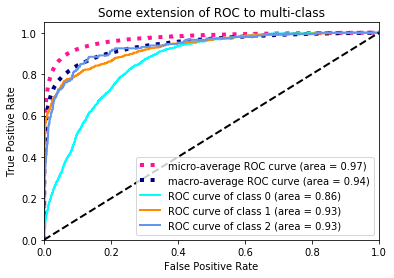

In [43]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

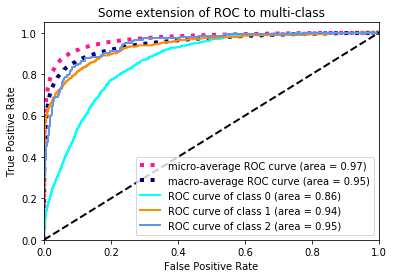

In [44]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

In [82]:
# Variations of c-> 0.1 to 100, L1 and L2 loss
c_lt = [0.1,1,5,10,50,100]
loss_lt = ['l1','l2']

for c in c_lt:
    for loss in loss_lt:
        print("C={}, Loss={}".format(c,loss))
        classifier_mybag = train_classifier(X_train_mybag, y_train, penalty=loss,c=c)
        classifier_tfidf = train_classifier(X_train_tfidf, y_train, penalty=loss,c=c)
        
        y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
        y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
        
        print('Bag-of-words')
        print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
        print('Tfidf')
        print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

C=0.1, Loss=l1
Bag-of-words
Accuracy = 0.3264
F1-Score = 0.6115946659713171
Precision = 0.33526527147186413
Tfidf


/Users/bhargav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy = 0.2870666666666667
F1-Score = 0.566426821440678
Precision = 0.2904938367933424
C=0.1, Loss=l2
Bag-of-words


/Users/bhargav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy = 0.3117333333333333
F1-Score = 0.5923791370558974
Precision = 0.3005916734957248
Tfidf
Accuracy = 0.18053333333333332
F1-Score = 0.3922289028503371
Precision = 0.09912226315178653
C=1, Loss=l1
Bag-of-words
Accuracy = 0.36766666666666664
F1-Score = 0.6597136636460678
Precision = 0.35905383503060956
Tfidf
Accuracy = 0.3653666666666667
F1-Score = 0.6524048237222565
Precision = 0.3492784380633158
C=1, Loss=l2
Bag-of-words
Accuracy = 0.3596666666666667
F1-Score = 0.6504085545292546
Precision = 0.3448398321031025
Tfidf
Accuracy = 0.3339666666666667
F1-Score = 0.614374123945813
Precision = 0.30203873557248717
C=5, Loss=l1
Bag-of-words
Accuracy = 0.34846666666666665
F1-Score = 0.6587831908275942
Precision = 0.33624605018387826
Tfidf
Accuracy = 0.36056666666666665
F1-Score = 0.6594420434026851
Precision = 0.3454570771124777
C=5, Loss=l2
Bag-of-words
Accuracy = 0.3592
F1-Score = 0.6582277101207832
Precision = 0.3412544090706567
Tfidf
Accuracy = 0.36443333333333333
F1-Score = 0.65149110

When you are happy with the quality, create predictions for *test* set, which you will submit to Coursera.

In [73]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)
test_predictions = y_test_predicted_labels_tfidf
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	html,javascript,jquery
2	
3	javascript,jquery
4	android,java
5	parsing,php,xml
6	json,...


### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [87]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    #estimator = classifier.estimators_
    coef = classifier.coef_[tags_classes.index(tag)]
    
    dict1 = {inx:coef[inx] for inx in range(len(coef))}
    sort_dict = sorted(dict1.items(), key= lambda x: x[1], reverse=True)
    
    top_positive_words = [index_to_words[i] for i,j in sort_dict[:5]]
    top_negative_words = [index_to_words[i] for i,j in sort_dict[-5:-1]]
    
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [88]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	c, malloc, php call, installing ruby, open url
Top negative words:	javascript, java, begin, swift

Tag:	c++
Top positive words:	c++, qt, stdstring, c++11, mfc
Top negative words:	c#, javascript, c++ stl, java

Tag:	linux
Top positive words:	linux, killed, write simple, reaching, calling php
Top negative words:	javascript, nokogiri, codeigniter, displaying



### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [74]:
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	html,javascript,jquery
2	
3	javascript,jquery
4	android,java
5	parsing,php,xml
6	json,...


In [75]:
STUDENT_EMAIL = 'bupadhyay148@gmail.com' 
STUDENT_TOKEN = 'NPXfdxcqFpHsIGKD' 
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	html,javascript,jquery
2	
3	javascript,jquery
4	android,java
5	parsing,php,xml
6	json,...


If you want to submit these answers, run cell below

In [76]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
